## Kaggle challenge first delivery

In [1]:
#https://www.kaggle.com/spencerpitts/european-hotel-reviews-r
#https://www.kaggle.com/gunnvant/what-do-reviews-say

In [38]:
#Installer les librairies (Utile seulement la première fois !)
##install.packages("devtools")
#install.packages("RColorBrewer")
#devtools::install_github("hadley/tidyverse")
#install.packages("tidytext")
#install.packages("viridis")  # Installer

#Charger les librairies
library("viridis")           
library(RColorBrewer)
library(tidyverse)
library(lubridate)
library(stringr)
library(forcats)
library(tidytext)
#library(sqldf)
#library(plotly)
#library(leaflet)
#library(leaflet.extras)
library(ggplot2)
library(wordcloud2)
#library(tm)

In [39]:
dataset = read.csv("../dataset/Hotel_Reviews.csv")

In [40]:
# check for if any null values are present in which columns
sapply(dataset, function(x)sum(is.na(x)))


Hotel_Address 
                                         0 
              Additional_Number_of_Scoring 
                                         0 
                               Review_Date 
                                         0 
                             Average_Score 
                                         0 
                                Hotel_Name 
                                         0 
                      Reviewer_Nationality 
                                         0 
                           Negative_Review 
                                         0 
         Review_Total_Negative_Word_Counts 
                                         0 
                   Total_Number_of_Reviews 
                                         0 
                           Positive_Review 
                                         0 
         Review_Total_Positive_Word_Counts 
                                         0 
Total_Number_of_Reviews_Reviewer_Has_Given 
                                         0 
                            Reviewer_Score 
                                         0 
                                      Tags 
                                         0 
                         days_since_review 
                                         0 
                                       lat 
                                      3268 
                                       lng 
                                      3268

In [41]:
head(summary(as.factor(dataset$Reviewer_Nationality)), n = 1) # getting top Nationality for na's


United Kingdom  
          245246

In [42]:
# can only run once without getting lat & lng errors!
dataset <- dataset %>%
  select(colnames(dataset), -lat,-lng, -Review_Total_Negative_Word_Counts, -Review_Total_Positive_Word_Counts, -Additional_Number_of_Scoring) %>%
  mutate(Positive_Review = ifelse(is.na(Positive_Review),
                                  "Nothing",
                                  Positive_Review)) %>%
  mutate(Negative_Review = ifelse(is.na(Negative_Review),
                                  "Nothing",
                                  Negative_Review))
sapply(dataset, function(x)sum(is.na(x)))
# good no more NAs!

Hotel_Address 
                                         0 
                               Review_Date 
                                         0 
                             Average_Score 
                                         0 
                                Hotel_Name 
                                         0 
                      Reviewer_Nationality 
                                         0 
                           Negative_Review 
                                         0 
                   Total_Number_of_Reviews 
                                         0 
                           Positive_Review 
                                         0 
Total_Number_of_Reviews_Reviewer_Has_Given 
                                         0 
                            Reviewer_Score 
                                         0 
                                      Tags 
                                         0 
                         days_since_review 
                                         0

In [43]:
dataset <- dataset %>%
  mutate(Review_Date = lubridate::mdy(Review_Date))
#summary(df)
# Time Series Analysis
# is the score dependent on time of year?
dataset <- dataset %>%
  mutate(Year = year(Review_Date)) %>%
  mutate(Month = month(Review_Date))
# credit to fellow kaggle user, GunnvantSaini
dataset <- dataset %>%
  mutate(Country = sapply(str_split(Hotel_Address," "),function(x){x[length(x)]}))

In [ ]:
# subsetting out lengthy columns, keeping hotel address and review data if
# needed to join
dataset_nlp <- dataset %>%
  select(Hotel_Name, Country, Review_Date, Year, Month,
         Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review, Reviewer_Nationality,
         Positive_Review,Total_Number_of_Reviews_Reviewer_Has_Given, Tags, Reviewer_Score)
dataset_clean <- dataset %>%
  select(Hotel_Name, Country, Review_Date, Year, Month, Average_Score,
         Reviewer_Nationality,Reviewer_Score,Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review,
         Positive_Review)
dataset_clean <- dataset_clean %>%
  mutate(Reviewer_Nationality = trimws(dataset_clean$Reviewer_Nationality, which = "both"))
print("Our dataset cleaned:" )
head(dataset_clean)
print("First column of NLP:" )
head(dataset_nlp, n = 1)

In [46]:
#dataset_clean
#ind=which(is.na(dataset_clean$Reviewer_Nationality))
#data_model=dataset_clean[-ind,]"""

dataset_clean$tourist=ifelse(dataset_clean$Reviewer_Nationality==dataset_clean$Country,"Yes","No")
dataset_clean$tourist=as.factor(dataset_clean$tourist)
table(dataset_clean$tourist)
#dataset_clean%>%group_by(Country,tourist)%>%summarise(average_score=mean(Average_Score))
#%>%ungroup()%>%mutate(Average_Score=average_score**7)%>%ggplot(aes(x=Country,y=Average_Score,color=tourist,fill=tourist))+geom_bar(stat='identity',position='dodge')+xlab("Country")+ylab("Average Score")+scale_y_continuous(breaks = NULL)



    No    Yes 
507984   7754 

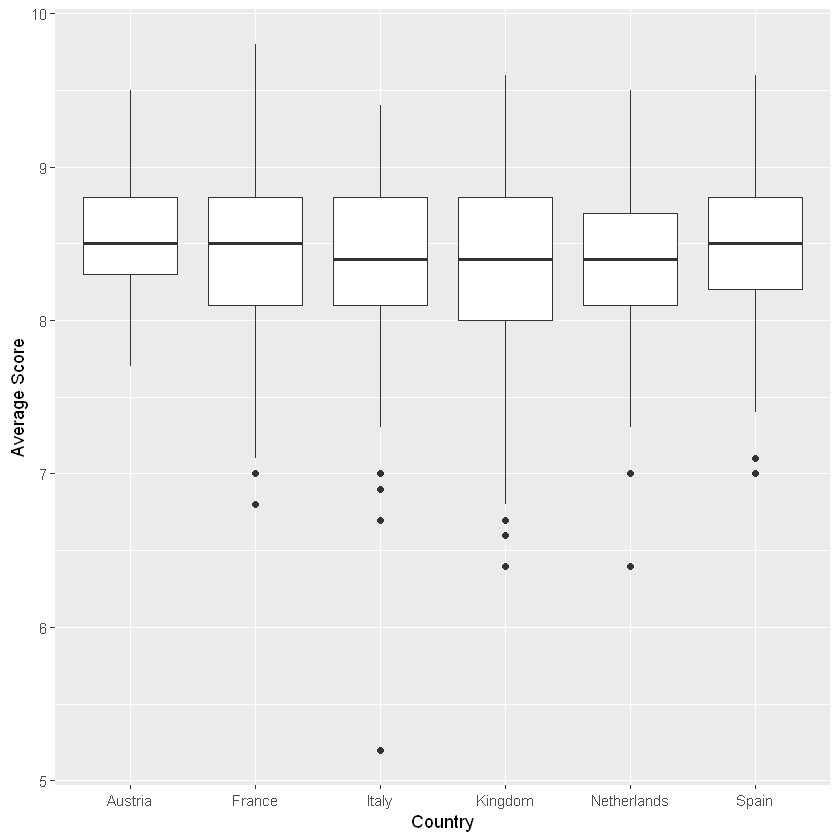

In [11]:
dataset_clean%>%ggplot(aes(x=as.factor(Country),y=Average_Score))+geom_boxplot()+xlab("Country")+ylab("Average Score")

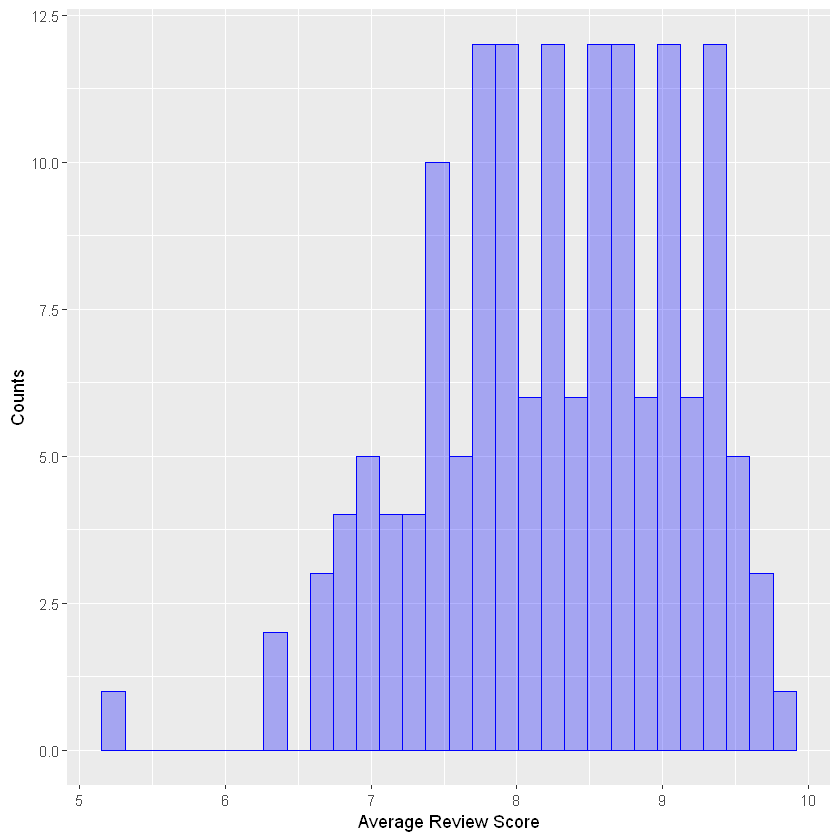

In [12]:
dataset_clean%>%select(Average_Score,Country)%>%distinct(Average_Score,Country)%>%ggplot(aes(x=Average_Score))+geom_histogram(color='blue',fill='blue',alpha=0.3,bins=30)+xlab("Average Review Score")+ylab("Counts")

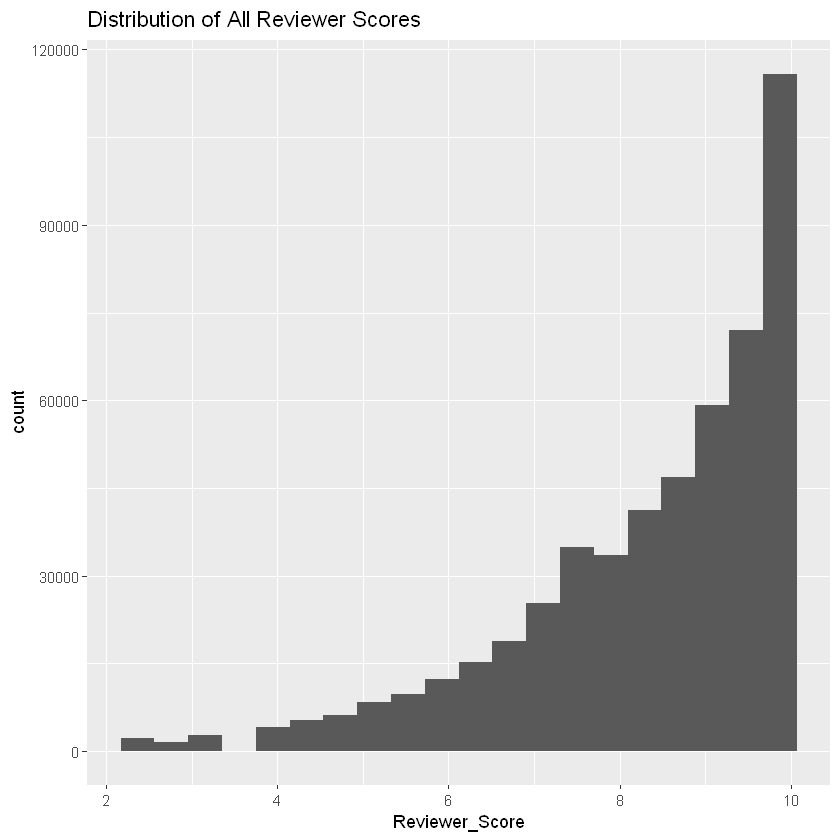

In [13]:
ggplot(dataset_clean, aes(Reviewer_Score))+
  geom_histogram(bins = 20) +
  ggtitle("Distribution of All Reviewer Scores")

In [14]:

#plot_world_cloud
reviews <- dataset_clean[sample(nrow(dataset_clean), 40000), ]
reviews <- reviews[reviews$Positive_Review!='Nothing',]
reviews <- reviews[reviews$Negative_Review!='Nothing',]
term_freq <- function(dataset_clean,sent){
  if(sent=='pos'){
    corpus <- Corpus(VectorSource(dataset_clean$Positive_Review))
  }else{
    corpus <- Corpus(VectorSource(dataset_clean$Negative_Review))
  }
  corpus <- tm_map(corpus, removeWords, stopwords("SMART"))
  corpus <- tm_map(corpus, removeWords, stopwords("en"))
  corpus <- tm_map(corpus, stripWhitespace)
  dtm <-TermDocumentMatrix(corpus)
  mat_dtm <- as.matrix(dtm)
  v_dtm <- sort(rowSums(mat_dtm),decreasing = TRUE)
  FreqMat <- data.frame(word = names(v_dtm), Freq = v_dtm)
  FreqMat <- FreqMat[1:50,]
  return(FreqMat)
}

In [18]:
wordcloud2(data = term_freq(reviews,'neg'), minRotation = 0, maxRotation = 0)

ERROR: Error in Corpus(VectorSource(data$Negative_Review)): impossible de trouver la fonction "Corpus"


In [19]:
dataset_country <- dataset %>%
  select(Hotel_Name, Country, Review_Date, Year, Month,
         Total_Number_of_Reviews_Reviewer_Has_Given, Negative_Review, Reviewer_Nationality,
         Positive_Review,Total_Number_of_Reviews_Reviewer_Has_Given, Tags, Reviewer_Score)
data = subset(dataset_country, Country == c("Austria"))
#plot_world_cloud
reviews <- data[sample(nrow(data), 4000), ]
reviews <- reviews[reviews$Positive_Review!='Nothing',]
reviews <- reviews[reviews$Negative_Review!='Nothing',]
term_freq <- function(data,sent){
  if(sent=='pos'){
    corpus <- Corpus(VectorSource(data$Positive_Review))
  }else{
    corpus <- Corpus(VectorSource(data$Negative_Review))
  }
  corpus <- tm_map(corpus, removeWords, stopwords("SMART"))
  corpus <- tm_map(corpus, removeWords, stopwords("en"))
  corpus <- tm_map(corpus, stripWhitespace)
  dtm <-TermDocumentMatrix(corpus)
  mat_dtm <- as.matrix(dtm)
  v_dtm <- sort(rowSums(mat_dtm),decreasing = TRUE)
  FreqMat <- data.frame(word = names(v_dtm), Freq = v_dtm)
  FreqMat <- FreqMat[1:50,]
  return(FreqMat)
}
wordcloud2(data = term_freq(reviews,'pos'),minRotation = 0,maxRotation = 0)

ERROR: Error in Corpus(VectorSource(data$Positive_Review)): impossible de trouver la fonction "Corpus"


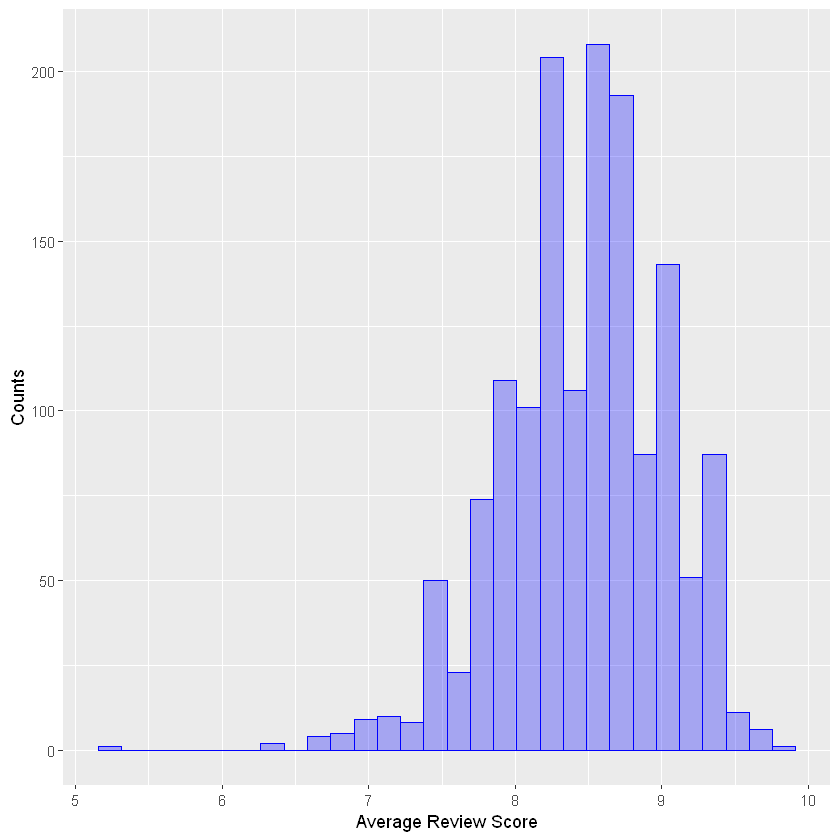

In [20]:
dataset_clean%>%select(Average_Score,Hotel_Name)%>%distinct(Average_Score,Hotel_Name)%>%ggplot(aes(x=Average_Score))+geom_histogram(color='blue',fill='blue',alpha=0.3,bins=30)+xlab("Average Review Score")+ylab("Counts")

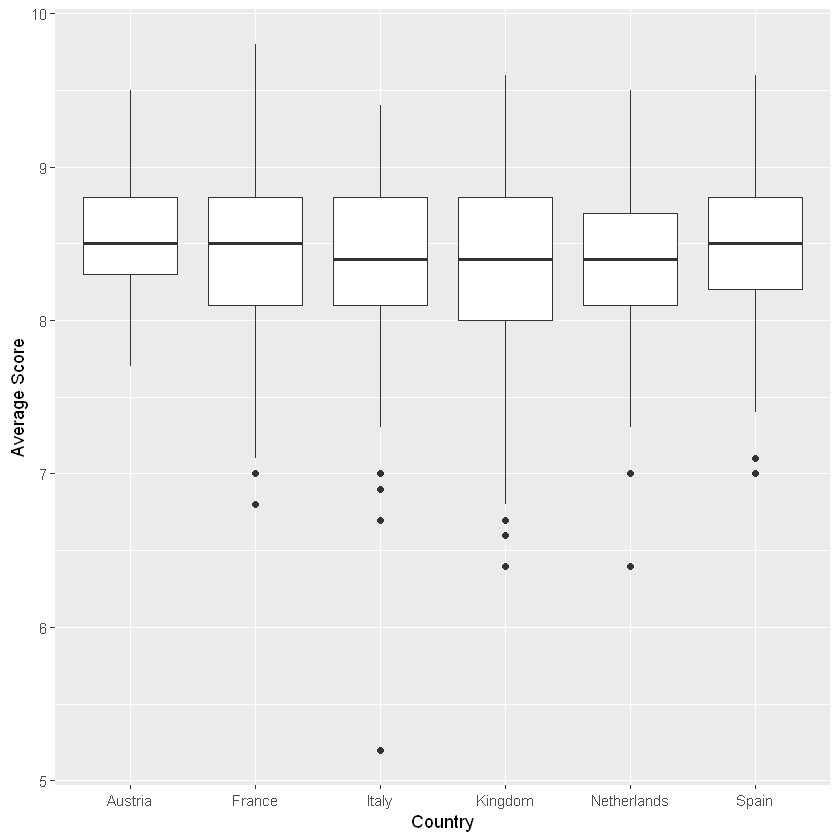

In [21]:
dataset%>%ggplot(aes(x=as.factor(Country),y=Average_Score))+geom_boxplot()+xlab("Country")+ylab("Average Score")

# Partie Floriane

Toutes les nationalités -> Valeurs trop inégales pour être lisibles
(Trouver un graphique plus adapté ?)
(Laisser pour montrer que ce pays a plus répondu au sondage que les autres ?)

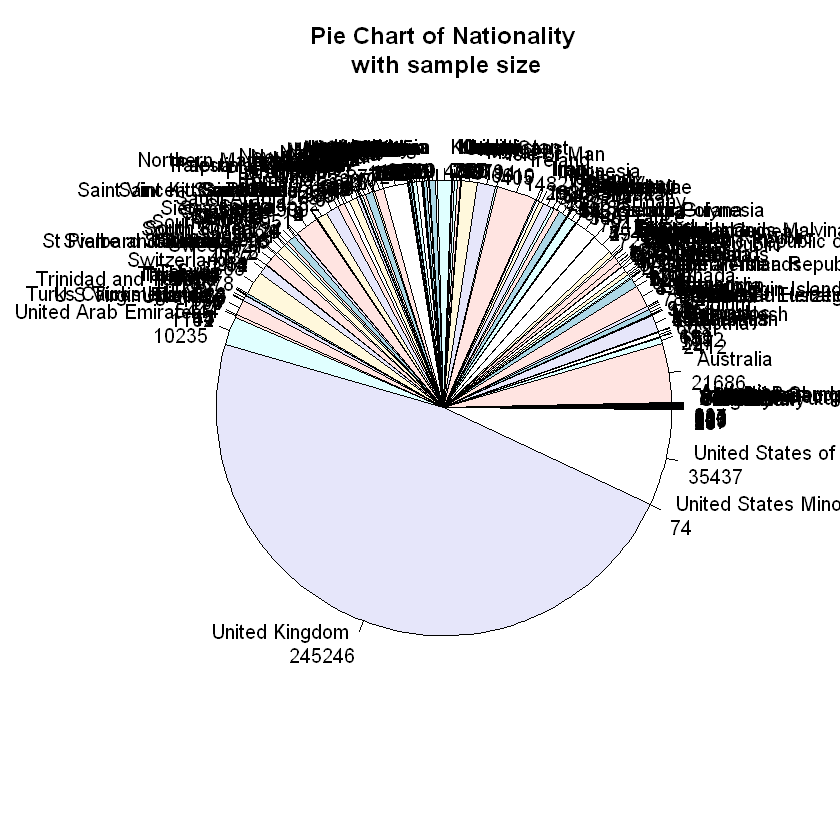

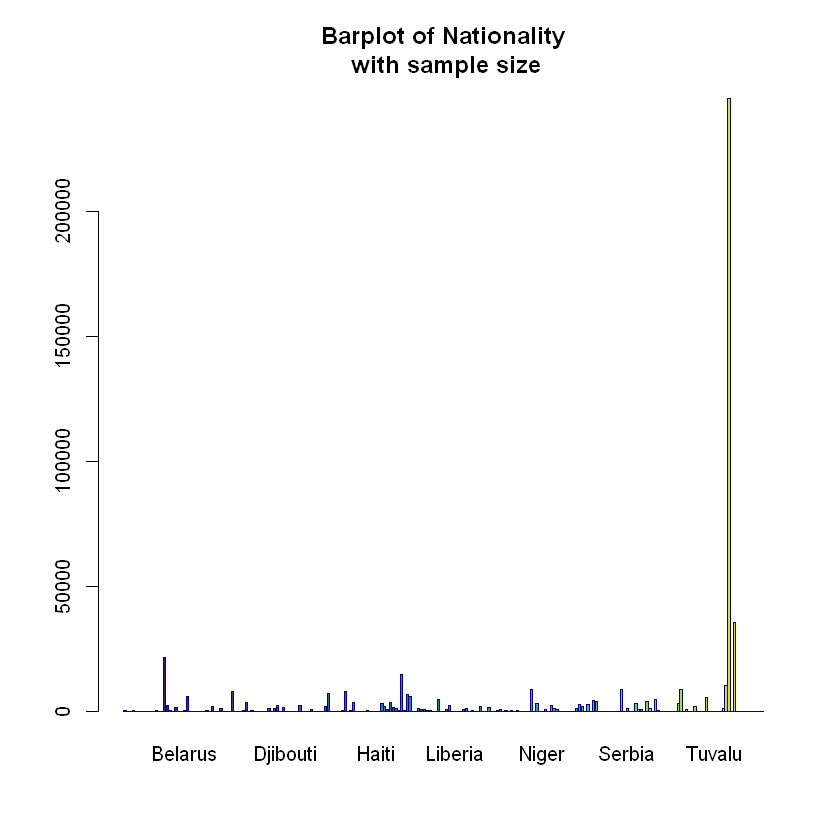

In [22]:
#PIECHART
nationalityTable <- table(dataset$Reviewer_Nationality)
pieNames <- paste(nationalityTable, sep="")
pieLabels <- paste(names(nationalityTable), "\n", nationalityTable, sep="")
pie(nationalityTable, labels = pieLabels,
    main="Pie Chart of Nationality\n with sample size")

#Barplot 
barplot(nationalityTable,
        col = viridis(length(nationalityTable)),
        border = "dark blue"
       )
title(main = "Barplot of Nationality\n with sample size")

Tous les pays -> Représenter seulement une valeur par hôtel, et non par reviewer

In [23]:
dataset_country = dataset_clean[0:2]
#print(dataset_country)

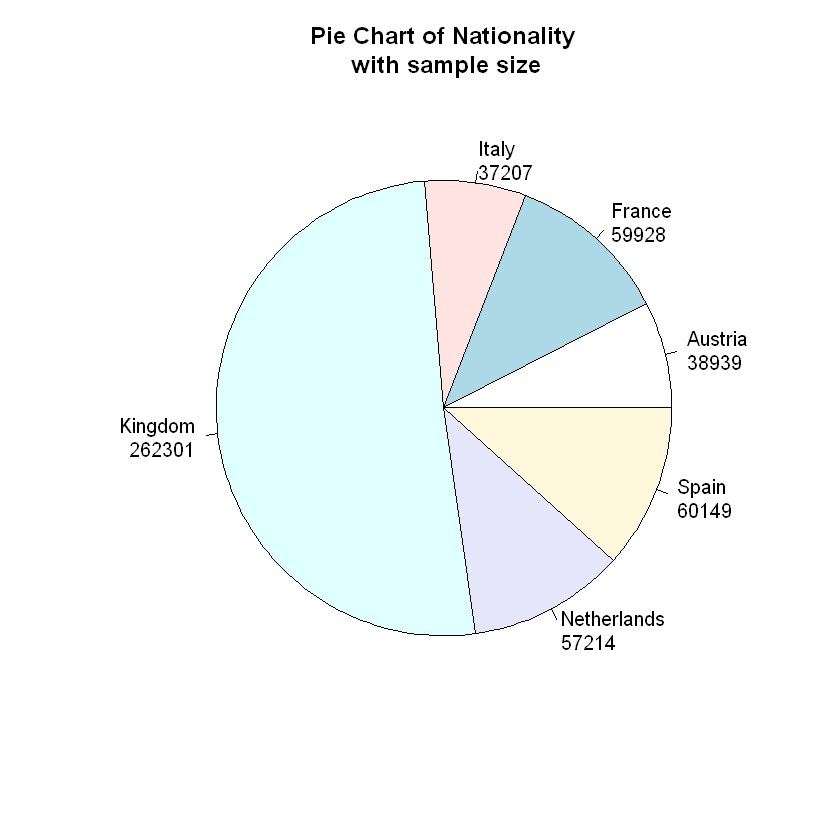

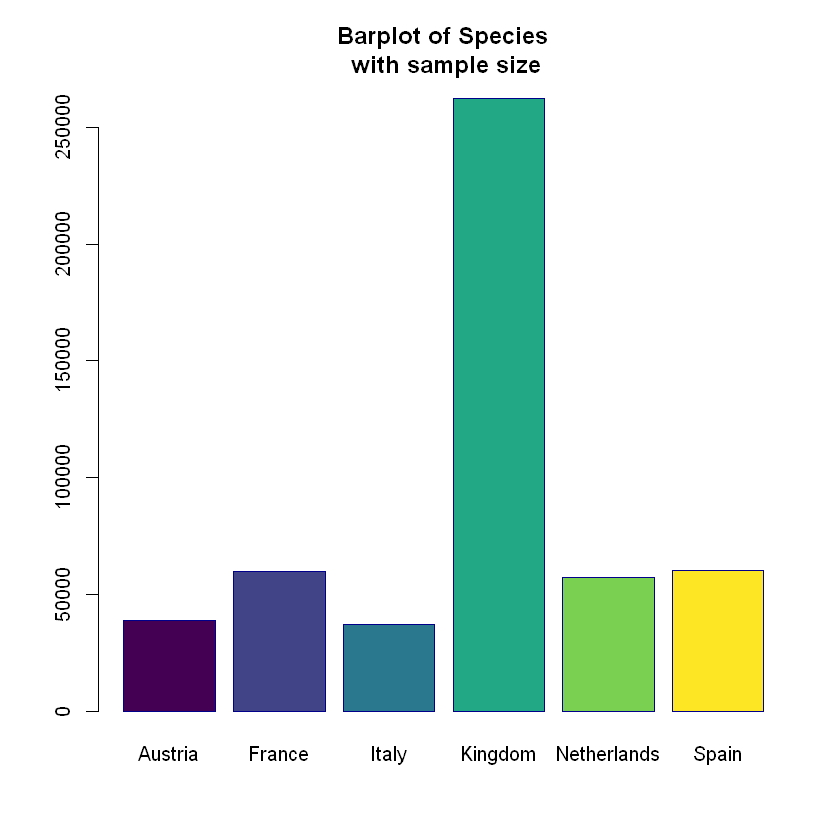

In [24]:
#PIECHART

countryTable <- table(dataset_clean$Country)
pieNames <- paste(countryTable, sep="")
pieLabels <- paste(names(countryTable), "\n", countryTable, sep="")
pie(countryTable, labels = pieLabels,
    main="Pie Chart of Nationality\n with sample size")

#Barplot 
barplot(countryTable, 
        col = viridis(length(countryTable)),
        border = "dark blue"
        )
title(main = "Barplot of Species\n with sample size")

`summarise()` has grouped output by 'Country'. You can override using the
`.groups` argument.


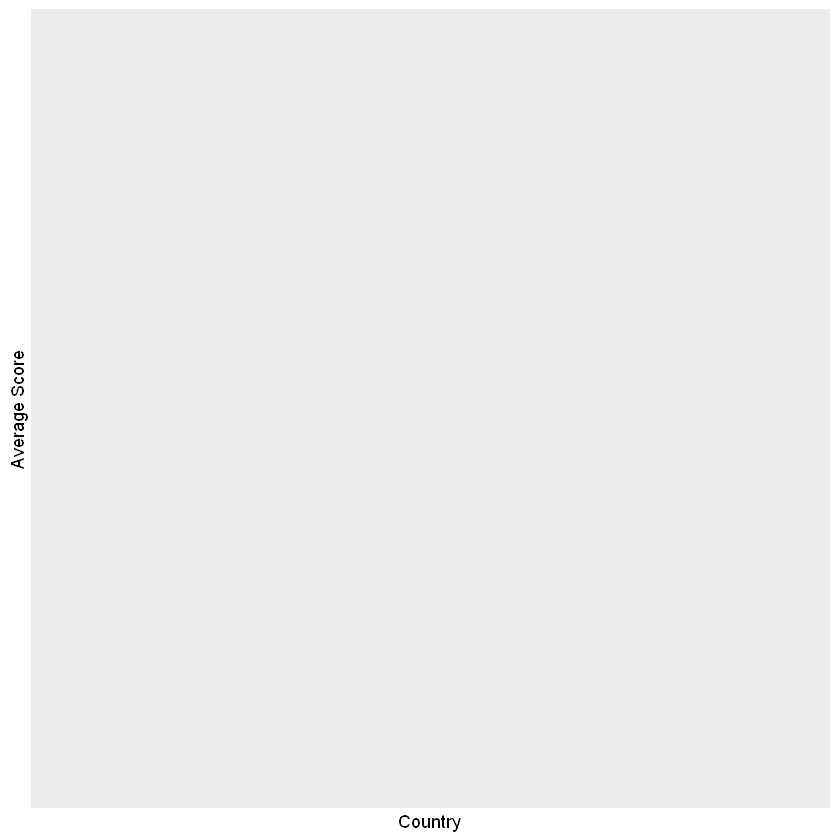

In [29]:
ind=which(is.na(dataset_clean$Reviewer_Nationality))
data_model=dataset_clean[-ind,]
data_model$tourist=ifelse(data_model$Reviewer_Nationality==data_model$Country,"Yes","No")
data_model$tourist=as.factor(data_model$tourist)
data_model%>%group_by(Country,tourist)%>%summarise(average_score=mean(Average_Score))%>%ungroup()%>%mutate(Average_Score=average_score**7)%>%ggplot(aes(x=Country,y=Average_Score,color=tourist,fill=tourist))+geom_bar(stat='identity',position='dodge')+xlab("Country")+ylab("Average Score")+scale_y_continuous(breaks = NULL)
